In [37]:
import pandas as pd

# Load raw LOBSTER message data
columns = ['time', 'type', 'order_id', 'size', 'price', 'direction']
lobster_df = pd.read_csv("aapl_lob.csv", header=None, names=columns)

# Keep only execution events: 4 (visible) and 5 (hidden)
executions = lobster_df[lobster_df['type'].isin([4, 5])].copy()

# Convert price from int to float (LOBSTER encodes prices as int * 10,000)
executions['price'] = executions['price'] / 10000

# Compute dollar value per trade
executions['dollar_value'] = executions['price'] * executions['size']

# Reset index
executions.reset_index(drop=True, inplace=True)

# Optional: convert time to readable format (seconds since midnight)
executions['time_seconds'] = executions['time']
executions['time'] = pd.to_datetime(executions['time'], unit='s', origin='2022-01-01')  # or any dummy base date


In [38]:
def build_tick_bars(df, threshold=100):
    bars = []
    for i in range(0, len(df), threshold):
        chunk = df.iloc[i:i+threshold]
        if not chunk.empty:
            bar = {
                'open_time': chunk['time'].iloc[0],
                'close_time': chunk['time'].iloc[-1],
                'open': chunk['price'].iloc[0],
                'high': chunk['price'].max(),
                'low': chunk['price'].min(),
                'close': chunk['price'].iloc[-1],
                'volume': chunk['size'].sum(),
                'dollar_value': chunk['dollar_value'].sum()
            }
            bars.append(bar)
    return pd.DataFrame(bars)


In [39]:
def build_volume_bars(df, threshold=10000):
    bars = []
    cum_vol = 0
    start_idx = 0

    for idx, row in df.iterrows():
        cum_vol += row['size']
        if cum_vol >= threshold:
            chunk = df.iloc[start_idx:idx+1]
            bar = {
                'open_time': chunk['time'].iloc[0],
                'close_time': chunk['time'].iloc[-1],
                'open': chunk['price'].iloc[0],
                'high': chunk['price'].max(),
                'low': chunk['price'].min(),
                'close': chunk['price'].iloc[-1],
                'volume': chunk['size'].sum(),
                'dollar_value': chunk['dollar_value'].sum()
            }
            bars.append(bar)
            start_idx = idx + 1
            cum_vol = 0
    return pd.DataFrame(bars)


In [40]:
def build_dollar_bars(df, threshold=1000000):
    bars = []
    cum_dollar = 0
    start_idx = 0

    for idx, row in df.iterrows():
        cum_dollar += row['dollar_value']
        if cum_dollar >= threshold:
            chunk = df.iloc[start_idx:idx+1]
            bar = {
                'open_time': chunk['time'].iloc[0],
                'close_time': chunk['time'].iloc[-1],
                'open': chunk['price'].iloc[0],
                'high': chunk['price'].max(),
                'low': chunk['price'].min(),
                'close': chunk['price'].iloc[-1],
                'volume': chunk['size'].sum(),
                'dollar_value': chunk['dollar_value'].sum()
            }
            bars.append(bar)
            start_idx = idx + 1
            cum_dollar = 0
    return pd.DataFrame(bars)


In [41]:
tick_bars = build_tick_bars(executions, threshold=1000)
volume_bars = build_volume_bars(executions, threshold=100000)
dollar_bars = build_dollar_bars(executions, threshold=10000000)


In [42]:
print("Tick bars:", len(tick_bars))
print("Volume bars:", len(volume_bars))
print("Dollar bars:", len(dollar_bars))


Tick bars: 35
Volume bars: 28
Dollar bars: 165


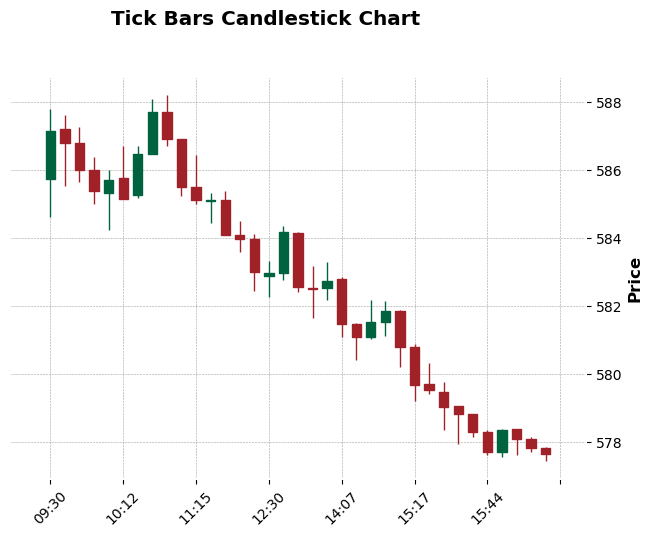

In [43]:
import mplfinance as mpf

# If open_time is already datetime, just rename and set index
tick_bars_mpf = tick_bars.copy()
tick_bars_mpf.rename(columns={'open_time': 'datetime'}, inplace=True)
tick_bars_mpf.set_index('datetime', inplace=True)

ohlc = tick_bars_mpf[['open', 'high', 'low', 'close']]

mpf.plot(ohlc, type='candle', style='charles', title="Tick Bars Candlestick Chart", ylabel="Price")



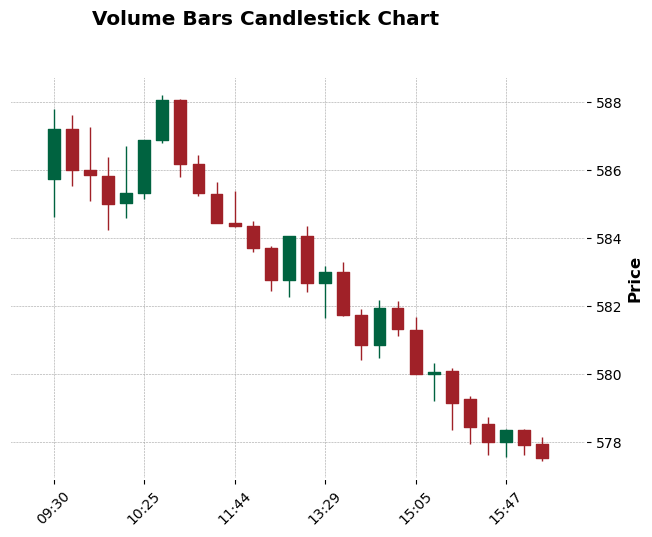

In [44]:
volume_bars_mpf = volume_bars.copy()
volume_bars_mpf.rename(columns={'open_time': 'datetime'}, inplace=True)
volume_bars_mpf.set_index('datetime', inplace=True)

ohlc_volume = volume_bars_mpf[['open', 'high', 'low', 'close']]

mpf.plot(ohlc_volume, type='candle', style='charles', title="Volume Bars Candlestick Chart", ylabel="Price")


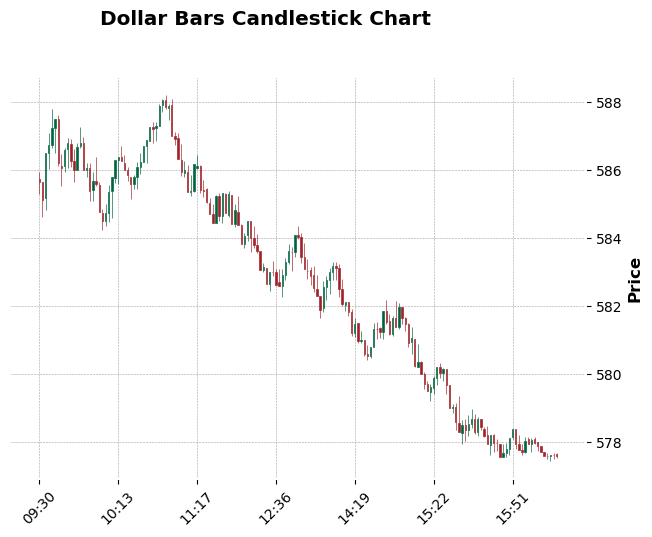

In [45]:
dollar_bars_mpf = dollar_bars.copy()
dollar_bars_mpf.rename(columns={'open_time': 'datetime'}, inplace=True)
dollar_bars_mpf.set_index('datetime', inplace=True)

ohlc_dollar = dollar_bars_mpf[['open', 'high', 'low', 'close']]

mpf.plot(ohlc_dollar, type='candle', style='charles', title="Dollar Bars Candlestick Chart", ylabel="Price")
